In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
zip_data = zipfile.ZipFile('/content/drive/MyDrive/MU-PROJEKAT/asl_alphabet.zip', 'r')
zip_data.extractall('/tmp')
zip_data.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

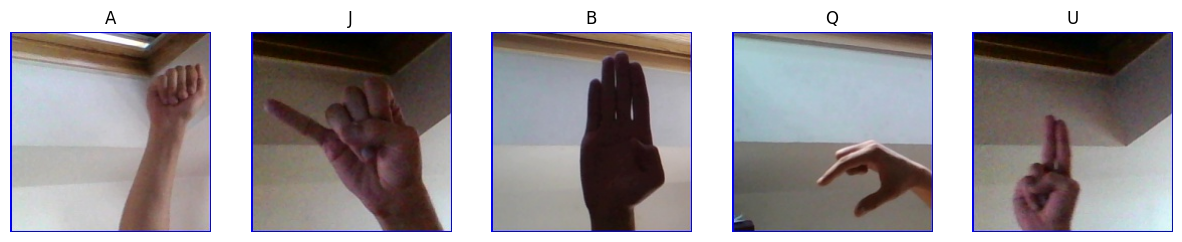

In [ ]:
import random
from PIL import Image
import os

input_dir = '/tmp/asl_alphabet_train/asl_alphabet_train'

image_paths = []
class_names = []
for root, dirs, files in os.walk(input_dir):
    for class_name in dirs:
        class_dir = os.path.join(root, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.jpg') or file.endswith('.png'):
                image_paths.append(os.path.join(class_dir, file))
                class_names.append(class_name)

# 5 random slika
random_indices = random.sample(range(len(image_paths)), 5)
random_images = [image_paths[idx] for idx in random_indices]
random_classes = [class_names[idx] for idx in random_indices]

plt.figure(figsize=(15, 10))
for i, (img_path, class_name) in enumerate(zip(random_images, random_classes)):
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{class_name}')
plt.show()

In [ ]:
from PIL import Image
import os

def remove_border(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    classes = os.listdir(input_dir)
    for class_name in classes:
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            if img_path.endswith(".jpg") or img_path.endswith(".png"):
                img = Image.open(img_path)
                img_no_border = img.crop((3, 3, img.width - 3, img.height - 3))
                img_no_border.save(os.path.join(output_class_dir, filename))

input_dir = '/tmp/asl_alphabet_train/asl_alphabet_train'
output_dir = '/tmp/asl_alphabet_train_no_border'

remove_border(input_dir, output_dir)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

data_dir = '/tmp/asl_alphabet_train_no_border'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode='sparse'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=32,
    subset='validation',
    class_mode='sparse'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
train_generator.class_indices.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

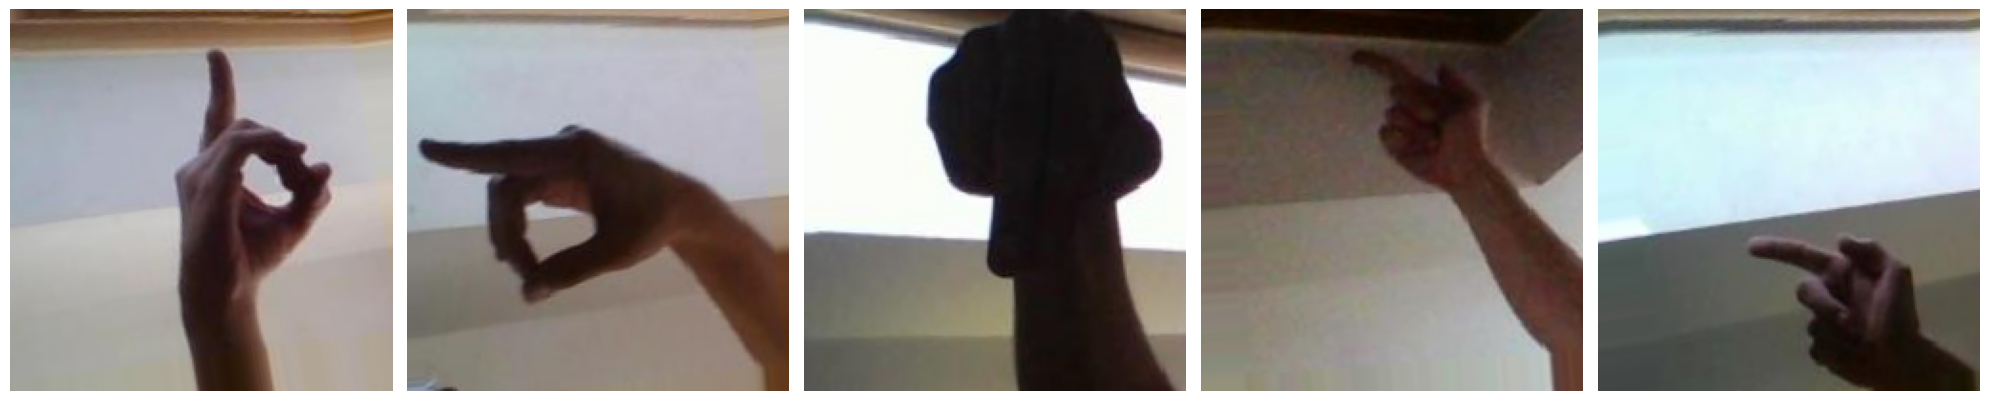

In [ ]:
augmented_images, labels = next(train_generator)

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(augmented_images[:5])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 99, 99, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
2175/2175 [==============================] - 899s 407ms/step - loss: 2.4833 - accuracy: 0.2536 - val_loss: 3.2395 - val_accuracy: 0.3040
Epoch 2/10
2175/2175 [==============================] - 887s 408ms/step - loss: 0.9415 - accuracy: 0.6760 - val_loss: 3.6723 - val_accuracy: 0.3637
Epoch 3/10
2175/2175 [==============================] - 898s 413ms/step - loss: 0.4374 - accuracy: 0.8450 - val_loss: 1.0635 - val_accuracy: 0.6899
Epoch 4/10
2175/2175 [==============================] - 889s 409ms/step - loss: 0.2988 - accuracy: 0.8973 - val_loss: 1.3566 - val_accuracy: 0.6766
Epoch 5/10
2175/2175 [==============================] - 877s 403ms/step - loss: 0.2344 - accuracy: 0.9198 - val_loss: 1.7370 - val_accuracy: 0.6203
Epoch 6/10
2175/2175 [==============================] - 866s 398ms/step - loss: 0.1924 - accuracy: 0.9357 - val_loss: 1.0212 - val_accuracy: 0.7332
Epoch 7/10
2175/2175 [==============================] - 893s 411ms/step - loss: 0.1685 - accuracy: 0.9437 - val_

In [ ]:
model.save("asl-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


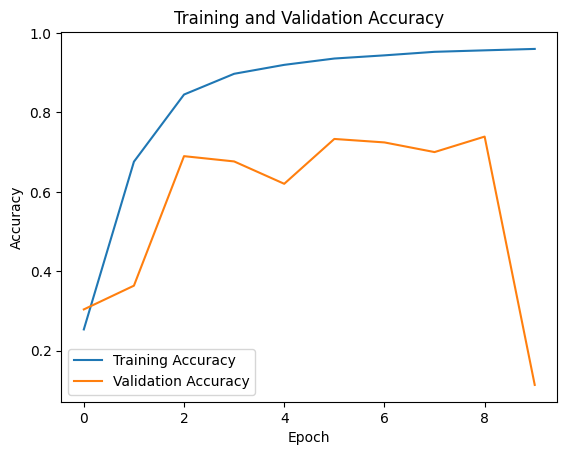

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()